In [1]:
!pip install gpxpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.6 MB/s eta 0:00:00


In [2]:
import gpxpy
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns

from math import radians, sin, cos, sqrt, atan2, tan
%matplotlib inline

In [15]:
from google.colab import files
import io

# Upload the GPX file
uploaded = files.upload()

# Assuming you uploaded a GPX file named "gpx_file.gpx"
file_name = list(uploaded.keys())[0]
gpx_content = uploaded[file_name]

# Create an in-memory file-like object from the uploaded content
gpx_file = io.StringIO(gpx_content.decode('utf-8'))

# Parse the GPX file
gpx = gpxpy.parse(gpx_file)

Saving output_trimmed.gpx to output_trimmed (1).gpx


In [16]:
# Create empty lists to store data
latitude = []
longitude = []
elevation = []
time = []
heartrate = []

# Iterate through the GPX data points
for track in gpx.tracks:
    for segment in track.segments:
        for point in segment.points:
            latitude.append(point.latitude)
            longitude.append(point.longitude)
            elevation.append(point.elevation if point.elevation is not None else 0)  # Handle None values
            time.append(point.time)
            if point.extensions:
                for ext in point.extensions:
                    for extchild in list(ext):
                        heartrate.append(int(extchild.text))
            else:
                heartrate.append(0)


# Create a DataFrame
data = {
    'Time': time,
    'Latitude': latitude,
    'Longitude': longitude,
    'Elevation': elevation,
    'Heartrate':heartrate

}
df = pd.DataFrame(data)

# Close the GPX file
gpx_file.close()

df

,Time,Latitude,Longitude,Elevation,Heartrate
0,2023-11-19 11:36:03+00:00,41.313104,1.938426,410.76,0
1,2023-11-19 11:41:38+00:00,41.313294,1.938463,413.56,0
2,2023-11-19 11:41:44+00:00,41.313493,1.938527,414.67,0
3,2023-11-19 11:41:49+00:00,41.313697,1.938580,415.11,0
4,2023-11-19 11:41:53+00:00,41.313902,1.938692,415.76,0
...,...,...,...,...,...
654,2023-11-19 12:21:06+00:00,41.266667,1.948555,6.69,0
655,2023-11-19 12:21:09+00:00,41.266670,1.948309,6.92,0
656,2023-11-19 12:21:12+00:00,41.266644,1.948057,6.39,0
657,2023-11-19 12:21:15+00:00,41.266630,1.947801,5.81,0


In [17]:

# Calculated params

# Cumulative Time

df['Cumulative_Time'] = (df['Time'] - df['Time'].min()).dt.total_seconds() / 60.0


# Cumulative_Distance in km

def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of the Earth in kilometers
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)

    a = np.sin(dlat / 2)**2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    distance = R * c  # Distance in kilometers
    return distance

df['Cumulative_Distance'] = np.cumsum(haversine(df['Latitude'].shift(), df['Longitude'].shift(), df['Latitude'], df['Longitude']).fillna(0))

# Velocity in km/h

df['Velocity'] = (df['Cumulative_Distance'].diff() / df['Cumulative_Time'].diff()) * 60  # Convert from minutes to hours

# Slope in degrees

skip_values = 2  # Set the number of values to skip for smoothing

df['Slope'] = np.degrees(np.arctan2(df['Elevation'].diff(periods=skip_values), df['Cumulative_Distance'].diff(periods=skip_values)*1000))


# Smoothed elevation

df['Smoothed_Elevation'] = df['Elevation'].rolling(window=10, min_periods=1).mean()


# Cumulative elevation

positive_changes = df['Smoothed_Elevation'].diff().clip(lower=0)
df['Cumulative_Elevation'] = positive_changes.cumsum()

# Smoothed Slope
df['Smooth_Slope'] = np.degrees(np.arctan2(df['Smoothed_Elevation'].diff(), df['Cumulative_Distance'].diff()*1000))


# Removing velocity outliers

# Calculate the average of adjacent values for each row
df['average_adjacent'] = df['Velocity'].rolling(window=3, center=False).mean()

# Identify the rows where the velocity is 2 or 3 times larger than the average of adjacent values
outlier_condition = (df['Velocity'] > 2 * df['average_adjacent'])

# Create a new column 'corrected_velocity' with the corrected values
df['Corrected_Velocity'] = np.where(outlier_condition, df['average_adjacent'], df['Velocity'])

# Drop the 'average_adjacent' column
df.drop(columns=['average_adjacent'], inplace=True)

# Additional smoothing
df['Corrected_Velocity']=df['Corrected_Velocity'].rolling(window=3, min_periods=1).mean()


df

,Time,Latitude,Longitude,Elevation,Heartrate,Cumulative_Time,Cumulative_Distance,Velocity,Slope,Smoothed_Elevation,Cumulative_Elevation,Smooth_Slope,Corrected_Velocity
0,2023-11-19 11:36:03+00:00,41.313104,1.938426,410.76,0,0.000000,0.000000,NaN,NaN,410.760000,NaN,NaN,NaN
1,2023-11-19 11:41:38+00:00,41.313294,1.938463,413.56,0,5.583333,0.021386,0.229820,NaN,412.160000,1.400000,3.745421,0.229820
2,2023-11-19 11:41:44+00:00,41.313493,1.938527,414.67,0,5.683333,0.044119,13.639710,5.064557,412.996667,2.236667,2.107780,6.934765
3,2023-11-19 11:41:49+00:00,41.313697,1.938580,415.11,0,5.766667,0.067237,16.644995,1.936159,413.525000,2.765000,1.309194,10.171509
4,2023-11-19 11:41:53+00:00,41.313902,1.938692,415.76,0,5.833333,0.091789,22.096569,1.309876,413.972000,3.212000,1.043037,17.460425
...,...,...,...,...,...,...,...,...,...,...,...,...,...
654,2023-11-19 12:21:06+00:00,41.266667,1.948555,6.69,0,45.050000,15.491658,23.677996,0.809674,5.945000,131.585000,0.043556,24.513999
655,2023-11-19 12:21:09+00:00,41.266670,1.948309,6.92,0,45.100000,15.512221,24.675479,0.745618,6.003000,131.643000,0.161609,24.146003
656,2023-11-19 12:21:12+00:00,41.266644,1.948057,6.39,0,45.150000,15.533498,25.533110,-0.410809,6.028000,131.668000,0.067319,24.628862
657,2023-11-19 12:21:15+00:00,41.266630,1.947801,5.81,0,45.200000,15.554924,25.710598,-1.488979,6.021000,131.668000,-0.018719,25.306396


In [6]:
# Statistics

timeMin = round(df['Cumulative_Time'].max(), 1)
timeH = round(timeMin / 60, 1)
distRound = round(df['Cumulative_Distance'].max(), 1)
max_speed = round(df['Corrected_Velocity'].max(), 1)
avg_speed = round(distRound / timeH, 1)
max_slope = round(df['Slope'].max(), 1)
max_hr = df['Heartrate'].max()
mean_hr = round(df['Heartrate'].mean())
max_height =  round(df['Elevation'].max())
cum_elevation =  round(df['Cumulative_Elevation'].max())

# Create a new DataFrame with the calculated values
stat_df = pd.DataFrame({
    'Time (min)': [timeMin],
    'Time (h)': [timeH],
    'Distance (km)': [distRound],
    'Max speed (km/h)': [max_speed],
    'Avg speed (km/h)': [avg_speed],
    'Max slope (º)': [max_slope],
    'Max HR (bpm)': [max_hr],
    'Mean HR (bpm)': [mean_hr],
    'Max height (m)': [max_height],
    'Cum. elevation (m)': [cum_elevation]
})
stat_df.index=['Value']
stat_df.transpose()

,Value
Time (min),47.4
Time (h),0.8
Distance (km),16.3
Max speed (km/h),58.6
Avg speed (km/h),20.4
Max slope (º),18.7
Max HR (bpm),0.0
Mean HR (bpm),0.0
Max height (m),439.0
Cum. elevation (m),146.0


Text(0, 0.5, 'Corrected Velocity (km/h)')

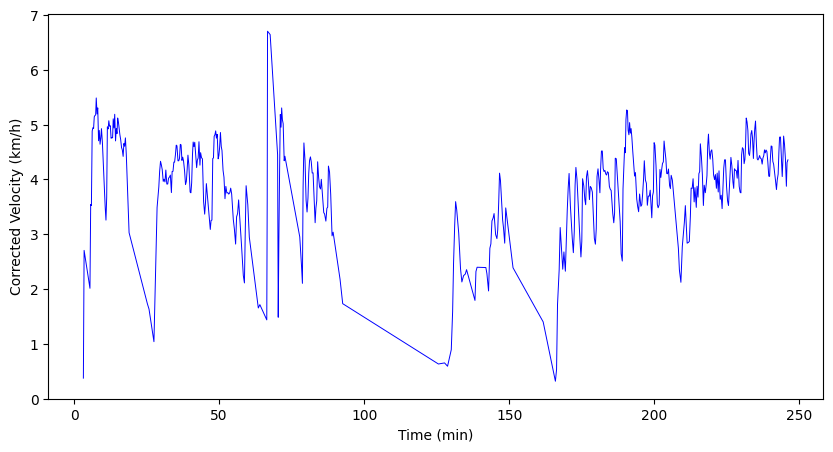

In [ ]:
#Plotting velocity

plt.figure(figsize=(10,5))
y=df['Corrected_Velocity']
x=df['Cumulative_Time']
plt.plot(x, y, 'b', lw = '0.7') # 'r' is the color red
#plt.xlim(140,150)
#plt.ylim(0,10)
plt.xlabel('Time (min)')
plt.ylabel('Corrected Velocity (km/h)')

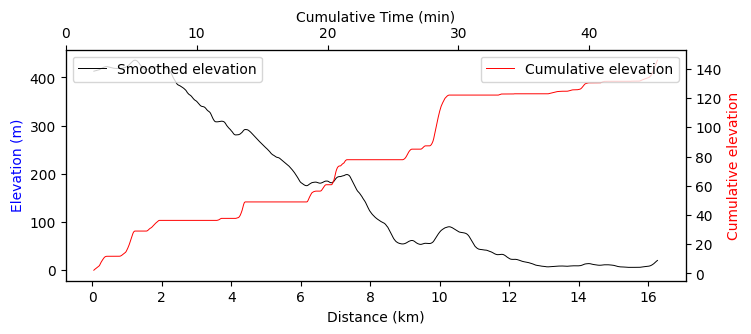

In [7]:
# Plotting elevation

fig, ax1 = plt.subplots(figsize=(8, 3))

# Plot Elevation against Cumulative Distance on the first y-axis
#ax1.plot(df['Cumulative_Distance'][2:], df['Elevation'][2:], label='Elevation', color='blue', lw = 0.7)
ax1.plot(df['Cumulative_Distance'][2:], df['Smoothed_Elevation'][2:], label='Smoothed elevation', color='black', lw = 0.7)
ax1.set_xlabel('Distance (km)')
ax1.set_ylabel('Elevation (m)', color='blue')


# Create a second y-axis for cum elevation
ax2 = ax1.twinx()
ax2.plot(df['Cumulative_Distance'][2:], df['Cumulative_Elevation'][2:], label='Cumulative elevation', color='red', lw = 0.7)
ax2.set_ylabel('Cumulative elevation', color='red')

# Create a second x-axis for Cumulative Time
ax3 = ax1.twiny()
ax3.plot(df['Cumulative_Time'], np.zeros_like(df['Cumulative_Time']), alpha=0)  # Plot a dummy line for the x-axis
ax3.set_xlim(df['Cumulative_Time'].iloc[0], df['Cumulative_Time'].iloc[-1])
ax3.set_xlabel('Cumulative Time (min)')

# Format the axes
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

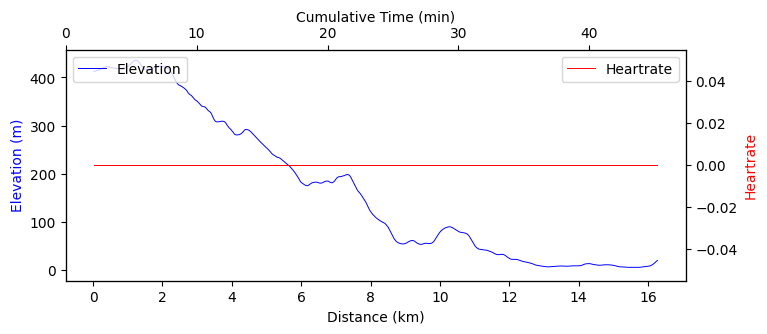

In [8]:
# Plotting elevation and HR

fig, ax1 = plt.subplots(figsize=(8, 3))

# Plot Elevation against Cumulative Distance on the first y-axis
ax1.plot(df['Cumulative_Distance'][1:], df['Smoothed_Elevation'][1:], label='Elevation', color='blue', lw = 0.7)
ax1.set_xlabel('Distance (km)')
ax1.set_ylabel('Elevation (m)', color='blue')

# Create a second y-axis for Heartrate
ax2 = ax1.twinx()
ax2.plot(df['Cumulative_Distance'][1:], df['Heartrate'][1:], label='Heartrate', color='red', lw = 0.7)
ax2.set_ylabel('Heartrate', color='red')

# Create a second x-axis for Cumulative Time
ax3 = ax1.twiny()
ax3.plot(df['Cumulative_Time'], np.zeros_like(df['Cumulative_Time']), alpha=0)  # Plot a dummy line for the x-axis
ax3.set_xlim(df['Cumulative_Time'].iloc[0], df['Cumulative_Time'].iloc[-1])
ax3.set_xlabel('Cumulative Time (min)')

# Format the axes
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

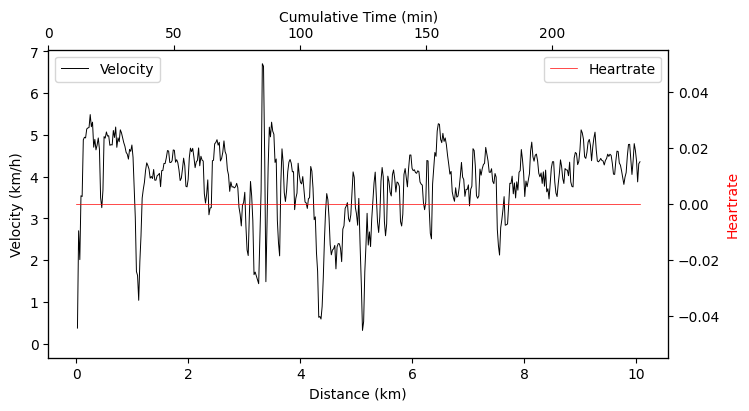

In [ ]:
# Plotting velocity and heartrate


fig, ax1 = plt.subplots(figsize=(8, 4))

# Plot Elevation against Cumulative Distance on the first y-axis
ax1.plot(df['Cumulative_Distance'], df['Corrected_Velocity'], label='Velocity', color='black', lw = 0.7)
ax1.set_xlabel('Distance (km)')
ax1.set_ylabel('Velocity (km/h)', color='black')

# Create a second y-axis for Slope
ax2 = ax1.twinx()
ax2.plot(df['Cumulative_Distance'], df['Heartrate'], label='Heartrate', color='red', lw = 0.5)
ax2.set_ylabel('Heartrate', color='red')

# Create a second x-axis for Cumulative Time
ax3 = ax1.twiny()
ax3.plot(df['Cumulative_Time'], np.zeros_like(df['Cumulative_Time']), alpha=0)  # Plot a dummy line for the x-axis
ax3.set_xlim(df['Cumulative_Time'].iloc[0], df['Cumulative_Time'].iloc[-1])
ax3.set_xlabel('Cumulative Time (min)')

# Format the axes
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

In [18]:
import folium

# Create a Folium map centered around the mean coordinates
map_center = [df['Latitude'].mean(), df['Longitude'].mean()]
my_map = folium.Map(location=map_center, zoom_start=15)

# Add the OpenTopoMap layer
opentopomap_url = 'https://a.tile.opentopomap.org/{z}/{x}/{y}.png'
folium.TileLayer(opentopomap_url, attr='OpenTopoMap').add_to(my_map)

# Create a PolyLine connecting the data points
points = list(zip(df['Latitude'], df['Longitude']))
folium.PolyLine(points, color='blue', weight=2.5, opacity=1).add_to(my_map)

# Plot data values using CircleMarkers (hidden markers)
for index, row in df.iterrows():
    popup_content = (
        f"Speed (km/h): {round(row['Corrected_Velocity'], 1)} <br> "
        f"HR (bpm): {row['Heartrate']} <br> "
        f"Time (min): {round(row['Cumulative_Time'], 1)} <br> "
        f"Distance (km): {round(row['Cumulative_Distance'], 2)} <br> "
        f"Slope: {round(row['Slope'], 1)}"
    )

    folium.CircleMarker([row['Latitude'], row['Longitude']],
                        radius=0.9,  # Set radius to 0 to hide the marker
                        color='blue',
                        fill_color='blue',
                        fill_opacity=0,
                        popup=folium.Popup(popup_content, max_width=300)).add_to(my_map)

# Add a marker for the maximum heart rate

max_hr_row = df.loc[df['Heartrate'].idxmax()]

folium.map.Marker(
    [max_hr_row['Latitude'], max_hr_row['Longitude']],
    icon=folium.DivIcon(html=f'<div style="font-size: 14px; color: black;">Max HR: {max_hr_row["Heartrate"]}</div>')
).add_to(my_map)

# Add a marker for the maximum speed

max_velocity_row = df.loc[df['Corrected_Velocity'].idxmax()]

folium.map.Marker(
    [max_velocity_row['Latitude'], max_velocity_row['Longitude']],
    icon=folium.DivIcon(html=f'<div style="font-size: 14px; color: black;">Max speed: {round(max_velocity_row["Corrected_Velocity"])}</div>')
).add_to(my_map)


my_map

Text(0, 0.5, 'Velocity')

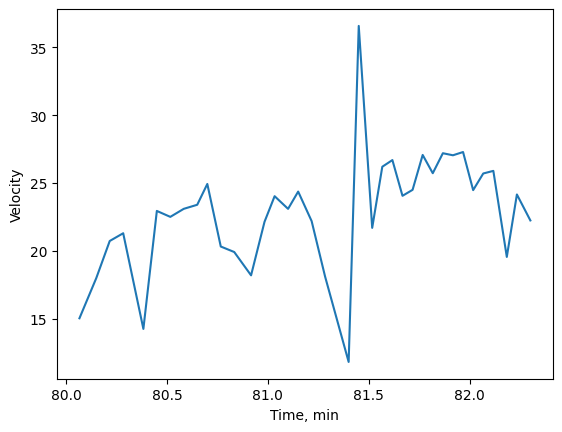

In [ ]:
#Plotting velocity (for Conconi test time limits)
start_time = 80
end_time = 84

# Filter DataFrame based on cumulative time
filtered_df = df[(df['Cumulative_Time'] >= start_time) & (df['Cumulative_Time'] <= end_time)]

# Plot the data
plt.plot(filtered_df['Cumulative_Time'],filtered_df['Velocity'])

plt.xlabel('Time, min')
plt.ylabel('Velocity')

In [ ]:
# Conconi test
'''
start_time = 39
end_time = 43.2
'''
start_time = 81
end_time = 84

# Filter DataFrame based on cumulative time
filtered_df = df[(df['Cumulative_Time'] >= start_time) & (df['Cumulative_Time'] <= end_time)]

# Plot the data
plt.scatter(filtered_df['Velocity'],filtered_df['Heartrate'])

plt.title('Conconi test')
plt.xlabel('Velocity, km/h')
plt.ylabel('Heartrate')

In [13]:
#Trimming the file
# Specify the minutes (check on the map) to find the row
target_value = 45.3

# Find the row number corresponding to the target value
row_number = df[(round(df['Cumulative_Time'],1)) == target_value ].index.item()

print(f"The row number corresponding to {target_value} min in 'Cumulative_Time' is {row_number}")
pd.DataFrame(df.iloc[row_number]).transpose()

The row number corresponding to 45.3 min in 'Cumulative_Time' is 659


,Time,Latitude,Longitude,Elevation,Heartrate,Cumulative_Time,Cumulative_Distance,Velocity,Slope,Smoothed_Elevation,Cumulative_Elevation,Smooth_Slope,Corrected_Velocity
659,2023-11-19 12:21:21+00:00,41.266576,1.94728,5.28,0,45.3,15.598964,26.754723,-0.689489,5.977,131.668,-0.020559,26.186321


In [14]:


from google.colab import files

def trim_gpx(gpx, output_file, num_points_to_keep):
    trimmed_gpx = gpxpy.gpx.GPX()

    for track in gpx.tracks:
        trimmed_track = gpxpy.gpx.GPXTrack()
        trimmed_gpx.tracks.append(trimmed_track)

        for segment in track.segments:
            trimmed_segment = gpxpy.gpx.GPXTrackSegment()
            trimmed_track.segments.append(trimmed_segment)

            # Keep only the first 'num_points_to_keep' points
            trimmed_segment.points = segment.points[:num_points_to_keep]

    # Save the trimmed GPX file
    with open(output_file, 'w') as trimmed_gpx_file:
        trimmed_gpx_file.write(trimmed_gpx.to_xml())

    # Download the saved file
    files.download(output_file)

output_filename = 'output_trimmed.gpx'
num_points_to_keep = row_number  # Adjust as needed

trim_gpx(gpx, output_filename, num_points_to_keep)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>